# Latency Threshold Testing

TJ Kim

6.28.21

### Summary:
- Run a stable queue system (1.5 service power ~ 1 arrival rate)
- Record queue cost given latency threshold, only recording value whenever we violate
- Latency threshold was set to np.random.randint(1,2).

In [1]:
cd /home/tkim/Academics/DistMEC

/home/tkim/Academics/DistMEC


In [2]:
import numpy as np
import math
import copy
import itertools

from classes.Application import *
from classes.User import *
from classes.Server import *
from solver.Sim_Params import *
from classes.Central_Controller import *
from classes.Container import *
from solver.run_sim_temp import *

In [3]:
num_trial = 10
threshold_sweep = [0,1,2,4]

In [4]:
# Cost recording
costs_l = {}
costs_q = {}

for t in range(num_trial):
    print('trial',t)

    sim_param = Sim_Params(big_ts=5, small_ts=5, x_length=5, y_length=5, num_users=20, num_servers=10, num_apps=5)
    servers, users, containers, apps = setup_sim(sim_param)

    for l in threshold_sweep:
        apps_temp = copy.deepcopy(apps)
        for a in apps_temp:
            a.latency_threshold = l
            a.offload_mode = 'd'
        apps_temp, _ = run_sim_temp(sim_param, servers, users, containers, apps_temp)

        costs_l[(t,l)] = 0
        costs_q[(t,l)] = 0

        for u in range(len(apps_temp)):
            for key in apps_temp[u].queue_length.keys():
                costs_l[(t,l)] += np.sum(apps_temp[u].queue_length[key][:,4] * apps_temp[u].queue_length[key][:,2])
                costs_q[(t,l)] += np.sum(apps_temp[u].queue_length[key][:,5] * apps_temp[u].queue_length[key][:,2])

trial 0
trial 1
trial 2
trial 3
trial 4
trial 5
trial 6
trial 7
trial 8
trial 9


### Plot Result

x axis is the latency threshold in number of small timesteps. y axis is monetary value.

In [5]:
# Analyse data and normalize - mean and SD of queue and length
l_collect = []
q_collect = []

for t in range(num_trial):
    for l in threshold_sweep:
        l_collect += [costs_l[(t,l)]]
        q_collect += [costs_q[(t,l)]]

l_collect = np.asarray(l_collect)
q_collect = np.asarray(q_collect)

l_mean = np.mean(l_collect)
l_std = np.std(l_collect)
q_mean = np.mean(q_collect)
q_std = np.std(q_collect)

In [6]:
print('latency_mean',l_mean)
print('latency_std',l_std)

print('queue_mean', q_mean)
print('queue_std', q_std)

latency_mean 7601.011295616889
latency_std 1106.2302711480925
queue_mean 14382.404184906156
queue_std 6088.872727773002


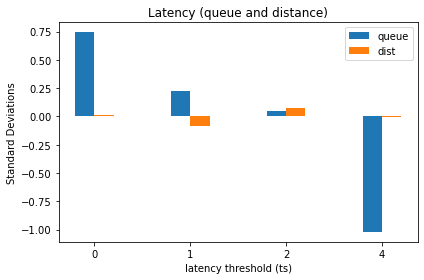

In [7]:
import matplotlib.pyplot as plt

n_vals_to_plot_q = []
n_vals_to_plot_l = []


for l in threshold_sweep:
    n_val_cumul_q = 0
    n_val_cumul_l = 0
    for t in range(num_trial):
        n_val_cumul_q += costs_q[(t,l)]/num_trial
        n_val_cumul_l += costs_l[(t,l)]/num_trial

    n_vals_to_plot_q += [(n_val_cumul_q-q_mean)/q_std]
    n_vals_to_plot_l += [(n_val_cumul_l-l_mean)/l_std]

# Plot the value
labels = threshold_sweep
q_vals = n_vals_to_plot_q
l_vals = n_vals_to_plot_l
width = 0.2  # the width of the bars

fig, ax = plt.subplots()
x = np.arange(len(labels))
rects1 = ax.bar(x - width/2, q_vals, width, label='queue')
rects2 = ax.bar(x + width/2, l_vals, width, label='dist')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Standard Deviations')
ax.set_xlabel('latency threshold (ts)')
ax.set_title('Latency (queue and distance)')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

fig.tight_layout()

plt.show()